# Supplementary Figure - overturning at 1000m isobath

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.colors as col
import matplotlib.path as mpath
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.gridspec as gs
import cmocean as cm
import matplotlib.patches as mpatches

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/easterlies/paper_figures/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38061,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:33649,Total threads: 4
Dashboard: /proxy/45131/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:34723,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'

start_time='2155-01-01'
end_time='2159-12-31'

lat_slice  = slice(-80,-50)
lon_slice  = slice(-280, 80)

In [4]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90
fontsize=16

In [5]:
ht = ht.sel(yt_ocean = slice(-80, -59)) 

In [6]:
exps = ['ctrl','up','down']

In [7]:
nfiles = 126
overturning = {}
for exp in exps:    
    if exp == 'ctrl':
        path = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies//Antarctic_cross_slope/*'))[:nfiles]
        vol_transp = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies//Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')
    elif exp == 'up':
        path = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/*'))[:nfiles]
        vol_transp = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')
    elif exp == 'down':
        path = np.sort(glob.glob('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_down10/Antarctic_cross_slope/*'))[:nfiles]
        vol_transp = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_down10/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc')

    for i in range(1, len(path)):
        vol_transp = xr.concat([vol_transp, xr.open_dataset(path[i])], dim = 'time')

    overturning[exp] = vol_transp['vol_trans_across_contour_binned'].sum('contour_index').sel(isopycnal_bins = slice(None, None, -1)).cumsum('isopycnal_bins')
    overturning[exp] = 1e-6*(overturning[exp]*vol_transp['ndays']).sum('time')/np.sum(vol_transp['ndays'])

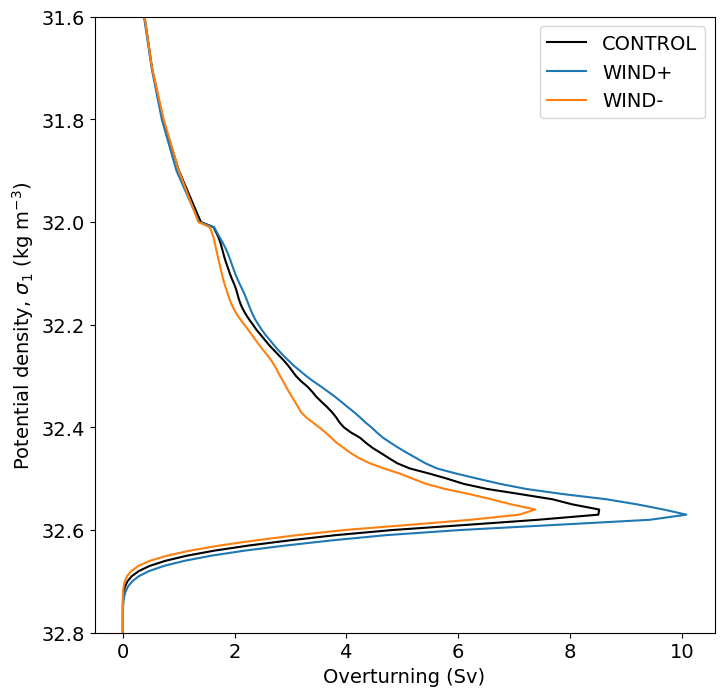

In [10]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (8, 8))

plt.plot(overturning['ctrl'], overturning['ctrl']['isopycnal_bins'], color = 'k',label='CONTROL')
plt.plot(overturning['up'], overturning['up']['isopycnal_bins'], color = 'C0',label='WIND+')
plt.plot(overturning['down'], overturning['down']['isopycnal_bins'], color = 'C1',label='WIND-')
plt.ylim(32.8, 31.6)
#plt.invert_yaxis()
plt.ylabel('Potential density, $\\sigma_{1}$ (kg m$^{-3}$)')
plt.xlabel('Overturning (Sv)')

plt.legend(fontsize=14)
plt.savefig(figdir + 'SuppFig4-overturning.pdf', bbox_inches = 'tight')